In [1]:
from pathlib import Path
import nibabel as nib
import numpy as np
import pandas as pd
import mne
from itertools import permutations
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib

In [31]:
def load_nb_vox(subject, file_name="aparc+aseg.mgz", exclude=()):
    path = fs_subject_path / subject / "mri" / file_name

    epi_img = nib.load(str(path))
    epi_img_data = np.asanyarray(epi_img.dataobj)

    nb_vox = pd.DataFrame(dict(zip(["id", "counts"], np.unique(epi_img_data, return_counts=True))))
    nb_vox["id"] = nb_vox["id"].astype(int)
    
    nb_vox = nb_vox.set_index("id")    
    nb_vox = nb_vox.drop(index=0)
    for id_ in exclude:
        try:
            nb_vox = nb_vox.drop(index=id_)
        except KeyError:
            continue

    nb_vox["proportion"] = nb_vox["counts"]/nb_vox["counts"].sum()

    lut = pd.DataFrame(mne.source_space._get_lut()).set_index("id")

    nb_vox["label"] = lut.loc[nb_vox.index, "name"]
    nb_vox["subject"] = subject    
    
    return nb_vox

In [25]:
def get_nb_vox_correl(file_name="aparc+aseg.mgz", regions=None, exclude=()):
    
    dfs = []
    for subject in subjects:
        dfs.append(load_nb_vox(subject, file_name, exclude=exclude))

    df = pd.concat(dfs)
    
    if regions is not None:
        df = df[np.in1d(df.label, regions)]

    rhos = []
    subjects1, subjects2 = list(zip(*permutations(subjects, 2)))
    for subject1, subject2 in zip(subjects1, subjects2):

        x = df[df["subject"] == subject1].merge(df[df["subject"] == subject2], on="label")
        rhos.append(np.corrcoef(x[["proportion_x", "proportion_y"]].T)[0, 1])

    cor_map = pd.DataFrame(dict(rhos=rhos, subjects1=subjects1, subjects2=subjects2))
    cor_map = cor_map.pivot_table(columns="subjects2", index="subjects1")["rhos"]
    
    return cor_map.loc[subjects, subjects]

In [4]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

age_dict = {"ANTS2-0Weeks3T": "0.5", "ANTS1-0Months3T": "1.0", 
            "ANTS2-0Months3T": "2.0", "ANTS3-0Months3T": "3.0", 
            "ANTS4-5Months3T": "4.5", "ANTS6-0Months3T": "6.0", 
            "ANTS7-5Months3T": "7.5", "ANTS9-0Months3T": "9.0", 
            "ANTS10-5Months3T": "10.5", "ANTS12-0Months3T": "12.0", 
            "ANTS15-0Months3T": "15.0", "ANTS18-0Months3T": "18.0", 
            "ANTS2-0Years3T": "24.0"}


subjects = ["ANTS2-0Weeks3T", "ANTS1-0Months3T", "ANTS2-0Months3T", "ANTS3-0Months3T", 
            "ANTS4-5Months3T", "ANTS6-0Months3T", "ANTS7-5Months3T", "ANTS9-0Months3T", 
            "ANTS10-5Months3T", "ANTS12-0Months3T", "ANTS15-0Months3T", "ANTS18-0Months3T", 
            "ANTS2-0Years3T"]
                
fs_subject_path = Path("/usr/local/freesurfer/subjects/")

In [5]:
x = load_nb_vox("ANTS12-0Months3T", "aparc+aseg.mgz")
subcortical = [label for label in x.label if not "ctx" in label]
cortical = [label for label in x.label if "ctx" in label]

# Available ASEG

In [6]:
dat = load_nb_vox("ANTS2-0Weeks3T", file_name="aseg.mgz")
dat = dat[["label", "counts"]].rename(columns={"counts":"ANTS2-0Weeks3T"})
for subject in subjects[1:]:
    tmp = load_nb_vox(subject, file_name="aseg.mgz")
    tmp = tmp[["label", "counts"]].rename(columns={"counts":subject})
    dat = dat.merge(tmp, on="label", how="outer")
    
aseg_availability = ~dat.isna()
aseg_availability["label"] = dat["label"]
aseg_availability

,label,ANTS2-0Weeks3T,ANTS1-0Months3T,ANTS2-0Months3T,ANTS3-0Months3T,ANTS4-5Months3T,ANTS6-0Months3T,ANTS7-5Months3T,ANTS9-0Months3T,ANTS10-5Months3T,ANTS12-0Months3T,ANTS15-0Months3T,ANTS18-0Months3T,ANTS2-0Years3T
0,Left-Cerebral-White-Matter,True,True,True,True,True,True,True,True,True,True,True,True,True
1,Left-Cerebral-Cortex,True,True,True,True,True,True,True,True,True,True,True,True,True
2,Left-Lateral-Ventricle,True,True,True,True,True,True,True,True,True,True,True,True,True
3,Left-Cerebellum-Cortex,True,True,True,True,True,True,True,True,True,True,True,True,True
4,Left-Thalamus,True,True,True,True,True,True,True,True,True,True,True,True,True
5,Left-Caudate,True,True,True,True,True,True,True,True,True,True,True,True,True
6,Left-Putamen,True,True,True,True,True,True,True,True,True,True,True,True,True
7,Left-Pallidum,True,True,True,True,True,True,True,True,True,True,True,True,True
8,3rd-Ventricle,True,True,True,True,True,True,True,True,True,True,True,True,True
9,4th-Ventricle,True,True,True,True,True,True,True,True,True,True,True,True,True


#### Available in all templates

In [7]:
aseg_availability.label[aseg_availability.min(1)].tolist()

['Left-Cerebral-White-Matter',
 'Left-Cerebral-Cortex',
 'Left-Lateral-Ventricle',
 'Left-Cerebellum-Cortex',
 'Left-Thalamus',
 'Left-Caudate',
 'Left-Putamen',
 'Left-Pallidum',
 '3rd-Ventricle',
 '4th-Ventricle',
 'Left-Hippocampus',
 'Left-Amygdala',
 'Left-Accumbens-area',
 'Left-VentralDC',
 'Right-Cerebral-White-Matter',
 'Right-Cerebral-Cortex',
 'Right-Lateral-Ventricle',
 'Right-Cerebellum-Cortex',
 'Right-Thalamus',
 'Right-Caudate',
 'Right-Putamen',
 'Right-Pallidum',
 'Right-Hippocampus',
 'Right-Amygdala',
 'Right-Accumbens-area',
 'Right-VentralDC',
 'Vermis',
 'Midbrain',
 'Pons',
 'Medulla']

#### Missing in some templates

In [22]:
missing_aseg = aseg_availability.label[aseg_availability.min(1) == 0].tolist()
missing_aseg

['Left-Cerebellum-White-Matter',
 'Right-Cerebellum-White-Matter',
 'Optic-Chiasm']

# Voxel proportion correlations

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


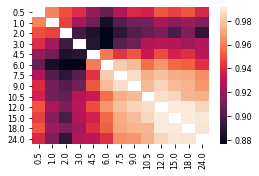

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(3.45, 2.25))

map_data = get_nb_vox_correl(file_name="aparc+aseg.mgz", regions=cortical)
map_data.index = [age_dict[template] for template in map_data.index.values]
map_data.columns = [age_dict[template] for template in map_data.columns.values]
sns.heatmap(map_data, ax=ax)

fig.tight_layout(pad=0)
fig.savefig("structural_cortical_correl.png", dpi=300)

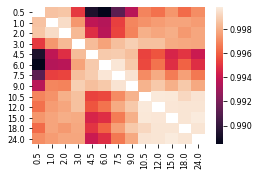

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(3.45, 2.25))

all_available_subcortical = ~np.in1d(subcortical, aseg_availability.label[aseg_availability.min(1) == 0].tolist())

map_data = get_nb_vox_correl(file_name="aparc+aseg.mgz", 
                              regions=np.array(subcortical)[all_available_subcortical])
map_data.index = [age_dict[template] for template in map_data.index.values]
map_data.columns = [age_dict[template] for template in map_data.columns.values]

sns.heatmap(map_data, ax=ax)
fig.tight_layout(pad=0)
fig.savefig("structural_subcortical_correl.png", dpi=300)

# Relative error per brain region

In [32]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 6}

sns.set_context("paper", font_scale=0.8)

exclude_region = [region_info[0] for region_info in mne.source_space._get_lut() if region_info[1] in missing_aseg]
dfs = []
for subject in subjects:
    dfs.append(load_nb_vox(subject, exclude=exclude_region))

df = pd.concat(dfs)

tmp = df.pivot_table(index="label", values="proportion", columns="subject")
relative_error = {}
for subject in subjects:
    relative_error[subject] = (tmp[subject]-tmp.mean(1))/tmp.mean(1)

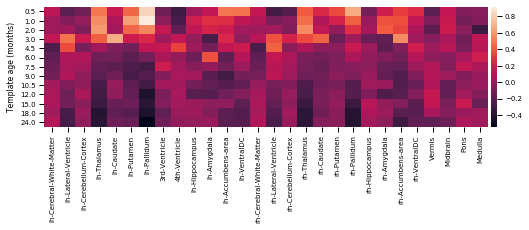

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(7.25, 3.0))

map_data = pd.DataFrame(relative_error).T[np.array(subcortical)[all_available_subcortical]]
map_data.index = [age_dict[template] for template in map_data.index.values]
map_data.columns = [region.replace("Left", "lh").replace("Right", "rh") for region in map_data.columns.values]


g = sns.heatmap(map_data, ax=ax, xticklabels=1, yticklabels=1)
gs = g.get_gridspec()
gs._wspace = 0.01
gs.set_width_ratios([0.92, 0.08])
ax.set_xlabel("")
ax.set_ylabel("Template age (months)")

fig.tight_layout(pad=0)
fig.savefig("structural_subcortical_relative_error.png", dpi=300)

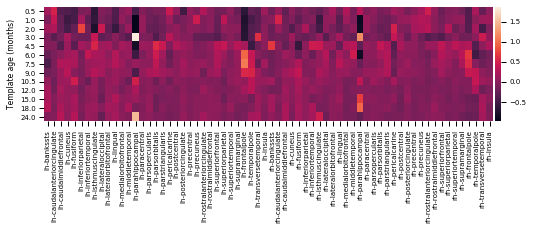

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7.25, 3.0))

map_data = pd.DataFrame(relative_error).T[cortical].dropna(axis=1)
map_data = map_data[[col for col in map_data.columns if "unknown" not in col]]
map_data.index = [age_dict[template] for template in map_data.index.values]
map_data.columns = [region.replace("ctx-", "") for region in map_data.columns.values]

g = sns.heatmap(map_data, ax=ax, xticklabels=1, yticklabels=1)
gs = g.get_gridspec()
gs._wspace = 0.01
gs.set_width_ratios([0.93, 0.07])

ax.set_ylabel("Template age (months)")
ax.set_xlabel("")
fig.tight_layout(pad=0)
fig.savefig("structural_cortical_relative_error.png", dpi=300)
